# Delay Prediction with RouteNet

The code below demonstrates how to use the RouteNetModel to predict the per-source/destination 
delay. First we provide an example of the mechanics by comparing a test sample of training data 
against a trained model, then we try the same trained model against a previously unseen network.

This code uses the sample data sets from the OMNet++ simulations, the structure of which
is explained in [OMNet++ Data Files and Formats](../OMNet_Data_Files_and_Formats.md).

## Training Network Data Sets

The trained model, which is saved in a checkpoint, is based on 480K training samples, including 240K 
samples from the 
[14-node NSF network data](http://knowledgedefinednetworking.org/data/datasets_v0/nsfnet.tar.gz) 

![14 Node NSF Topology](assets/nsfnet_topology.png)

and 240K samples from the 
[50-node synthetically-generated topology data](http://knowledgedefinednetworking.org/data/datasets_v0/synth50.tar.gz).

![50-node synthetically-generated topology](assets/synth50_topology.png)

## Test Network Data Sets

The test data set is illustrated below.

The [Geant2 network data](http://knowledgedefinednetworking.org/data/datasets_v0/geant2.tar.gz) has 24 nodes.

![Geant2 Topology](assets/geant2_topology.png)

In [1]:
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/gdrive')
    pipped = False
except:
    IN_COLAB = False

In [2]:
import sys

if IN_COLAB:
    %tensorflow_version 1.x
    ! git clone https://github.com/Data-Science-Projects/demo-routenet.git
    if not pipped:
        ! pip install -r demo-routenet/requirements.txt   
        pipped = True
    sys.path.append('/content/demo-routenet/demo_notebooks')
    sys.path.append('/content/demo-routenet/src')
    sys.path.append('/content/demo-routenet/tests')
else:
    sys.path.append('.')
    sys.path.append('../src')
    sys.path.append('../tests')

import rn_notebook_utils as nb_utils
import rn_test_utils.test_utils as test_utils

%load_ext autoreload
%autoreload 2

W1113 19:21:58.194809 4754681280 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
# First get a sample file from the geant2bw network.
omnet_data_dir = None
if IN_COLAB:
    omnet_data_dir = '/content/gdrive/My Drive/rn_data/'

sample_file = nb_utils.get_sample('geant2bw', omnet_data_dir=omnet_data_dir)

# Then create a RoutNetModel instance and initialise its readout layer with a sample from the 
# `sample_file`.
pred_graph, pred_readout, itrtr, labels = test_utils.get_model_readout(sample_file)

# We now have a readout Sequential model initialised with the sample data, and so the network that
# data represents, with training set to True, within the `pred_graph` Graph.  

W1113 19:21:58.402500 4754681280 deprecation.py:506] From /Users/nsowatsk/Dropbox/AI_ML_MSc./RouteNet/demo-routenet/bin/routenet_venv/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
******** in call ******************
W1113 19:21:59.465332 4754681280 deprecation.py:323] From /Users/nsowatsk/Dropbox/AI_ML_MSc./RouteNet/demo-routenet/bin/routenet_venv/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:253: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W1113 19:21:59.633594 4754681280 deprecation.py:323] From /Users/nsowatsk/Dropbox/AI_ML_MSc./RouteNet/de

In [4]:
# We can now create a session with that graph, and restore into the session the variables from a
# model checkpoint, i.e. we can transfer the weights from the previously trained model.
models_dir = '../trained_models/baseline'
if IN_COLAB:
    models_dir = 'demo-routenet/trained_models/baseline'

median_preds, predicted_delays, true_delay, mse, r2 = test_utils.run_predictions(pred_graph, 
                                                                                 pred_readout, 
                                                                                 itrtr, 
                                                                                 labels, 
                                                                                 260380,
                                                                                 models_dir)

W1113 19:22:01.810704 4754681280 deprecation.py:323] From /Users/nsowatsk/Dropbox/AI_ML_MSc./RouteNet/demo-routenet/bin/routenet_venv/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [5]:
mse

0.015751492

In [6]:
r2

0.9863807304241833

At this point we have the per-source/destination delay values predicted by RouteNet. 

Now we can compare the predictions from RouteNet with the true values. 

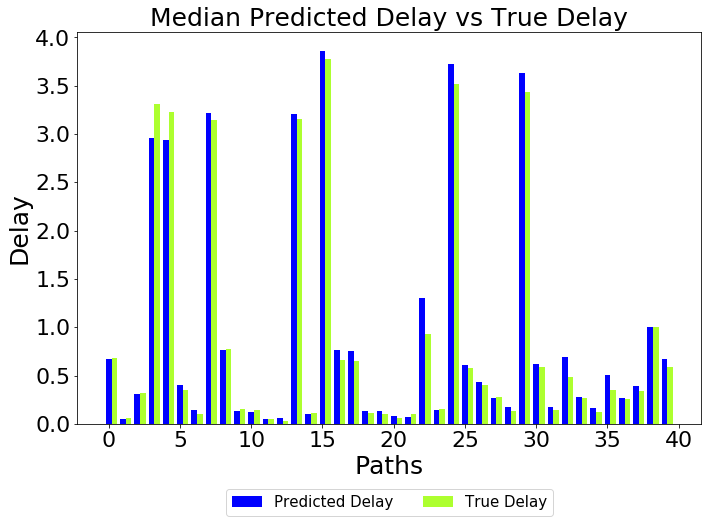

In [7]:
num_paths = 40 # Number of paths to visualize, and so size of sample.

plot_preds, plot_labels = nb_utils.get_plot_sample(median_preds, true_delay, num_paths)
nb_utils.plot_pred_vs_true_bar(plot_preds, plot_labels, num_paths)

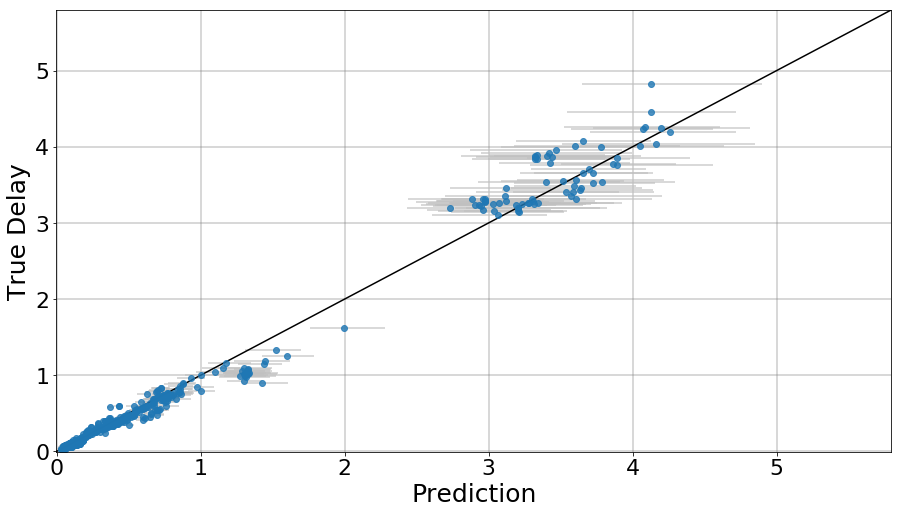

In [8]:
nb_utils.plot_pred_vs_true_scatter(median_preds, predicted_delays, true_delay)

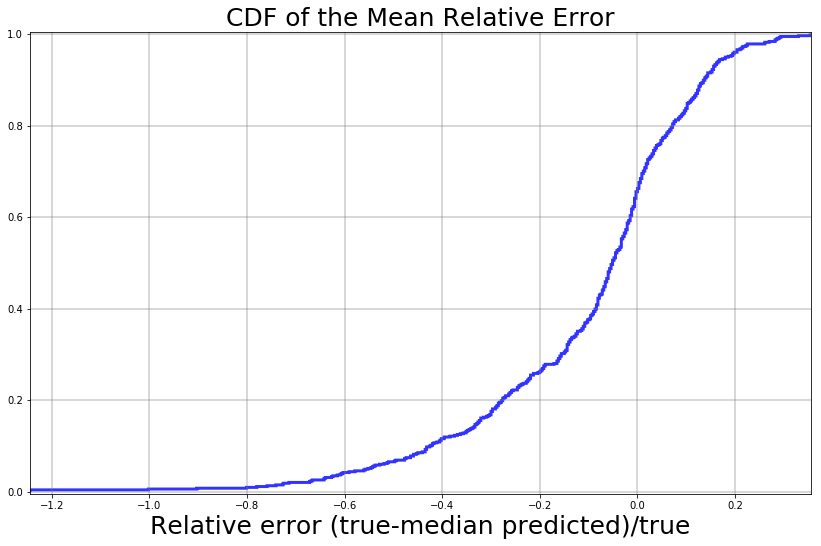

In [9]:
nb_utils.plot_cdf(true_delay, median_preds)

# References

Rusek, K., Suárez-Varela, J., Mestres, A., Barlet-Ros, P., & Cabellos-Aparicio, A. (2019, April). 
Unveiling the potential of Graph Neural Networks for network modeling and optimization in SDN. 
In Proceedings of the 2019 ACM Symposium on SDN Research (pp. 140-151). ACM.

This prediction demonstration is based on this 
[demo notebook](https://github.com/knowledgedefinednetworking/demo-routenet/blob/master/demo_notebooks/demo.ipynb)
Copyright 2019 José Suárez-Varela, Sergi Carol-Bosch, Krzysztof Rusek, Paul Almasan, Marta Arias, Pere Barlet-Ros, 
Albert Cabellos-Aparicio.
Universitat Politècnica de Catalunya, AGH University of Science and Technology
Licensed under the MIT License (the "License"), see end.

In [21]:
#@title Licensed under the MIT License (the "License"); { display-mode:"form" }
# MIT License

# Copyright (c) 2019 Paul Almasan, José Suárez-Varela, Krzysztzof Rusek

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

